## Problem set #3


### Q1 1.5
##### For each of the causal relationships, name a hypothetical third variable that would lead to an interaction effect. Please say if the interaction you describe is categorical or continous.

(1) Pedalling speed increases bicycle speed

The effect of pedalling speed on bicycle speed depends on what gear the bicycle is in. This is a categorical interaction

(2) Bread dough rises because of yeast

the effect of yeast on the rise of bread can depend on the salt content of the dough. This is a continuous interaction

(3) More exposure to the sun leads to higher probability of skin cancer

The effect of the sun on skin cancer risk can depend on sunscreen use. This can be coded as either continuous or categorical (e.g. no use/ some use/ daily use)

### Q2 1.5
##### For each of the previous relationships,write a linear model of the relationship which includes the interaction term.

(1) BicycleSpeed ~ Normal(mu,sigma)
    
    mu = a[gear] + B1[gear]*log(PedalSpeed - mean(PedalSpeed))
    
(2) Rise ~ Normal(mu, sigma)

    mu = a + B1*Yeast + B2*Salt + B3*Yeast*Salt
    
    
(3) Cancer ~ Bernouilli(p)
    
    logit(p) = a[SunScreen] + B1[SunScreen]*SunExposure

### Q3 2
##### Which of the following explanations invokes an interaction?

(1) Caramelizing onions requires cooking over low heat and making sure the onions do not
dry out.

This is an interaction: the effect of heat on caramelization depends on maintaining water content

(2) A car will go faster when it has more cylinders or when it has a better fuel injector.

This is not an interaction: cylinders and fuel injectors increase car speed independently

(3) Most people acquire their political beliefs from their parents, unless they get them instead
from their friends.

This is not an interaction: the effect of parents political beliefs does not depend on friends, but the effect of friends can be stronger than the effect of parents

(4) Intelligent animal species tend to be either highly social or have manipulative appendages
(hands, tentacles, etc.).

This is not an interaction: both sociality and manipulative appendages independently affect intelligence




### Q4 3 
##### Load in the "tulips"dataset. Fit a linear model using quap of the effect of water and shade on the number of blooms. To do this, center water and shade on their respective means and scale the number of blooms by the maximum. Then, fit a model including water and shadePresent a summary and a forest plot of the estimates and interpret them.


In [2]:
# Q4

import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import pandas as pd
import pymc3 as pm
from quap import quap
import arviz as az
import statsmodels.api as sm
import math

d = pd.read_csv("./../data/tulips.csv", delimiter=";")

d["water_centered"] = d.water-d.water.mean()
d["shade_centered"] = d.shade-d.shade.mean()
d["blooms_scaled"] = d.blooms/d.blooms.max()

with pm.Model() as tulip_m1:
    a = pm.Normal("a",0.75,0.2)
    b_water = pm.Normal("b_water",0,0.5)
    b_shade = pm.Normal("b_shade",0,0.5)
    sigma = pm.Exponential("sigma",1)
    
    mu = a + b_water*d.water_centered + b_shade*d.shade_centered
    
    Blooms = pm.Normal("Blooms",mu, sigma, observed=d.blooms_scaled)
    
    idata, dist = quap(vars=[a,b_water,b_shade,sigma])
    samples = az.InferenceData.to_dataframe(idata)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [112]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.366,0.030,0.318,0.413
b_water,0.208,0.038,0.149,0.268
b_shade,-0.114,0.037,-0.175,-0.057
sigma,0.158,0.022,0.124,0.194


The mean intercept is 0.36, meaning that the most likely average number of blooms for average water and average shade is 36% of the maximum.

Water is predicted to increase the number of blooms by 20% of the maximum (with 89% hdi between 0.15 and 0.27) for each unit increase in water.

Shade is predicted to decrease the nu,ber of blooms by 12% of the maximum (with 89% hdi between -0.173 and -0.055) for each unit increase in shade.

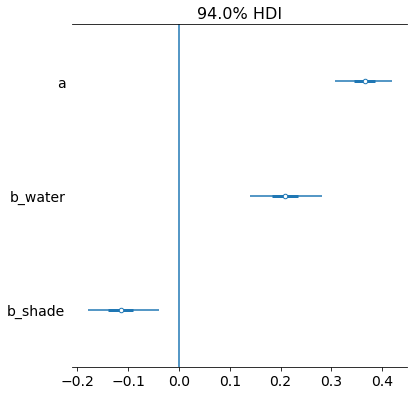

In [113]:
az.plot_forest(
    idata,
    var_names=["a","b_water", "b_shade"],
)
plt.axvline(0) 

### Q5 3
##### For the previous model, plot on the same graph the mean predicted effect of water on blooms for each of the values of shade. You should have a plot with 3 roughly parallel lines. running through them.



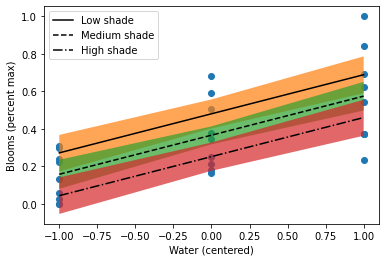

In [114]:
water_seq = [-1,0,1]
mu_pred_1 = np.zeros((len(water_seq), len(samples)))
mu_pred_2 = np.zeros((len(water_seq), len(samples)))
mu_pred_3 = np.zeros((len(water_seq), len(samples)))

for i, w in enumerate(water_seq):
    mu_pred_1[i] = samples["a"] + samples["b_water"] * w + samples["b_shade"] * (-1)

    mu_pred_2[i] = samples["a"] + samples["b_water"] * w

    mu_pred_3[i] = samples["a"] + samples["b_water"] * w + samples["b_shade"] * (1)

    
plt.scatter(d.water_centered, d.blooms_scaled)
plt.plot(water_seq, mu_pred_1.mean(1), "k", label='Low shade')
plt.fill_between(water_seq, np.quantile(mu_pred_1,0.055,axis=1), np.quantile(mu_pred_1,0.945,axis=1), alpha=0.7)

plt.plot(water_seq, mu_pred_2.mean(1), "k--", label='Medium shade')
plt.fill_between(water_seq, np.quantile(mu_pred_2,0.055,axis=1), np.quantile(mu_pred_2,0.945,axis=1), alpha=0.7)

plt.plot(water_seq, mu_pred_3.mean(1), "k-.", label='High shade')
plt.fill_between(water_seq, np.quantile(mu_pred_3,0.055,axis=1), np.quantile(mu_pred_3,0.945,axis=1), alpha=0.7)

plt.xlabel("Water (centered)")
plt.ylabel("Blooms (percent max)")
plt.legend()
plt.show()


### Q6 4
##### Rerun the same model as in Q4 but with the interaction term between water and shade. Again present a summary and forest plot and interpret the results. Recreate the same plot as in Q6 but now with the interaction term. The three lines should not be paralell any more.

In [119]:
with pm.Model() as tulip_m2:
    a = pm.Normal("a",0.75,0.2, shape = 3)
    b_water = pm.Normal("b_water",0,0.5, shape = 3)
    sigma = pm.Exponential("sigma",1)
    
    mu = a[d.shade-1] + b_water[d.shade-1]*d.water_centered
    
    Blooms = pm.Normal("Blooms",mu, sigma, observed=d.blooms_scaled)
    
    idata2, dist = quap(vars=[a,b_water,sigma])
    samples2 = az.InferenceData.to_dataframe(idata2)
    

In [120]:
az.summary(idata2, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],0.508,0.039,0.449,0.572
a[1],0.319,0.039,0.259,0.383
a[2],0.287,0.039,0.225,0.351
b_water[0],0.366,0.049,0.287,0.442
b_water[1],0.181,0.049,0.102,0.258
b_water[2],0.076,0.048,0.000,0.155
sigma,0.119,0.016,0.092,0.145


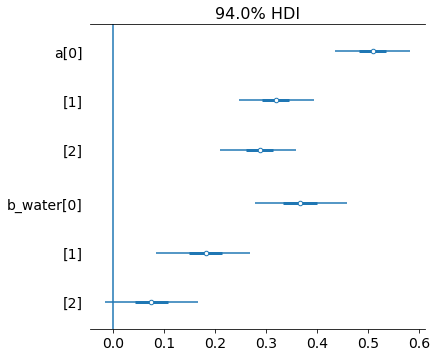

In [121]:
az.plot_forest(
    idata2,
    var_names=["a","b_water"],
)
plt.axvline(0) 

These parameter estimates suggest that the positive effect of water on  blooms only exists in conditions of low or medium shade, and that it is strongest in conditions of low shade.

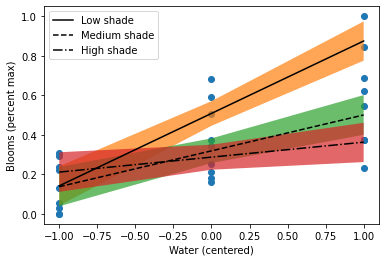

In [122]:
water_seq = [-1,0,1]
mu_pred_1 = np.zeros((len(water_seq), len(samples2)))
mu_pred_2 = np.zeros((len(water_seq), len(samples2)))
mu_pred_3 = np.zeros((len(water_seq), len(samples2)))

for i, w in enumerate(water_seq):
    mu_pred_1[i] = samples2[('a[0]',0)] + samples2[('b_water[0]',0)] * w 

    mu_pred_2[i] = samples2[('a[1]',1)] + samples2[('b_water[1]',1)] * w

    mu_pred_3[i] = samples2[('a[2]',2)] + samples2[('b_water[2]',2)] * w 


plt.scatter(d.water_centered, d.blooms_scaled)
plt.plot(water_seq, mu_pred_1.mean(1), "k", label='Low shade')
plt.fill_between(water_seq, np.quantile(mu_pred_1,0.055,axis=1), np.quantile(mu_pred_1,0.945,axis=1), alpha=0.7)

plt.plot(water_seq, mu_pred_2.mean(1), "k--", label='Medium shade')
plt.fill_between(water_seq, np.quantile(mu_pred_2,0.055,axis=1), np.quantile(mu_pred_2,0.945,axis=1), alpha=0.7)

plt.plot(water_seq, mu_pred_3.mean(1), "k-.", label='High shade')
plt.fill_between(water_seq, np.quantile(mu_pred_3,0.055,axis=1), np.quantile(mu_pred_3,0.945,axis=1), alpha=0.7)

plt.xlabel("Water (centered)")
plt.ylabel("Blooms (percent max)")
plt.legend()
plt.show()


### Q7 2
##### Now include the bed variable as a predictor in the interaction model. Don’t interact bed with the other predictors; just include it as a main effect. Note that bed is categorical. So to use it properly, you will need to either construct dummy variables or rather an index variable, as explained in Chapter 5 (page 155-156. 



In [123]:
# First let's recode bed as a number
d.bed = d.bed.replace(["a","b","c"],[0,1,2])

In [124]:
with pm.Model() as tulip_m3:
    a = pm.Normal("a",0.75,0.2, shape = 3)
    b_water = pm.Normal("b_water",0,0.5, shape = 3)
    b_bed = pm.Normal("b_bed",0,0.5, shape = 3)
    sigma = pm.Exponential("sigma",1)
    
    mu = a[d.shade-1] + b_water[d.shade-1]*d.water_centered + b_bed[d.bed]
    
    Blooms = pm.Normal("Blooms",mu, sigma, observed=d.blooms_scaled)
    
    idata3, dist = quap(vars=[a,b_water,b_bed,sigma])
    samples3 = az.InferenceData.to_dataframe(idata3)
    

### Q8 3
##### In 2007, The Wall Street Journal published an editorial (“We’re Number One, Alas”) with a graph of corporate tax rates in 29 countries plotted against tax revenue. A badly fit curve was drawn in, seemingly by hand, to make the argument that the relationship between tax rate and tax revenue increases and then declines, such that higher tax rates can actually produce less tax revenue. I want you to actually fit a curve to these data, found in Laffer.csv. Consider models that use tax rate to predict tax revenue. Compare, using WAIC or LOO, a straight-line model to any curved models you like. What do you conclude about the relationship between tax rate and tax revenue?

In [17]:
d2 = pd.read_csv("./../data/Laffer.csv", delimiter=",")

d2["tax_rate_std"] = (d2.tax_rate - d2.tax_rate.mean())/np.std(d2.tax_rate)
d2["tax_rev_std"] = (d2.tax_revenue - d2.tax_revenue.mean())/np.std(d2.tax_revenue)

with pm.Model() as m_Laffer_straight:
    a = pm.Normal("a",0,0.5)
    b1 = pm.Normal("b1",0,0.5)
    sigma = pm.Exponential("sigma",1)
    
    mu = a + b1*d2.tax_rate_std
    
    tax_revenue = pm.Normal("tax_revenue", mu,sigma, observed = d2.tax_rev_std)
    idata4 = pm.sample(return_inferencedata=True)
    samples4 = az.InferenceData.to_dataframe(idata4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.


In [18]:
az.summary(idata4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.174,-0.321,0.320,0.003,0.003,4668.0,2751.0,1.01
b1,0.283,0.178,-0.056,0.605,0.003,0.002,4459.0,2940.0,1.00
sigma,1.007,0.140,0.753,1.261,0.002,0.002,3936.0,2861.0,1.00


In [19]:
with pm.Model() as m_Laffer_curved:
    a = pm.Normal("a",0,1)
    b1 = pm.Normal("b1",0,0.5)
    b2 = pm.Normal("b2",0,0.5)
    sigma = pm.Exponential("sigma",1)
    
    mu = a + b1*d2.tax_rate_std + b2*d2.tax_rate_std**2
    
    tax_revenue = pm.Normal("tax_revenue", mu,sigma, observed = d2.tax_rev_std)
    idata5 = pm.sample(return_inferencedata=True, tune=1000)
    samples5 = az.InferenceData.to_dataframe(idata5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.


In [25]:
az.compare({"m_Laffer_straight":idata4,"m_Laffer_curved":idata5},ic="loo",scale="deviance")

C:\Users\edsea\miniconda3\envs\stat-rethink2\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\edsea\miniconda3\envs\stat-rethink2\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\Users\edsea\miniconda3\envs\stat-rethink2\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consi

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_Laffer_curved,0,88.420057,6.129892,0.000000,0.647775,19.747584,0.000000,True,deviance
m_Laffer_straight,1,88.675131,5.179389,0.255074,0.352225,18.767605,1.927056,True,deviance


The LOO comparison shows that the quadratic model is significantly better fit to the data than the simple linear model, suggestin there are at least diminishing returns to increasing the tax rate.